## DR vs PCA comparisons

In [1]:
from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib
from functools import partial
import sys, glob, os, copy
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from data_modules import DATA_MODULES
import dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, DATA_PATH_FLOWERS_PETS, SERVER_PROJECT_PATH

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'}
}

In [3]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNING_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

In [4]:
def save_predictions(model_path, out):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    torch.save({'pred': out[0].detach().cpu(), 'gt': out[2].detach().cpu()}, preds_path)

def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)


def get_test_acc(model, mode, source_dataset, finetuning_dataset, checkpoint_path, model_path, seed, fraction):
    state_dict = torch.load(model_path)
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else \
            DATA_PATH_FLOWERS_PETS if finetuning_dataset in ['flowers','oxford-iiit-pets'] else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset,
                                            inference_kwargs={'with_latent': True}),
                           loading_function_kwargs={'strict': False})
    
    if mode == 'pca':
        append = model_path.split('/')[-2].split('-')[-1]
        base_path = '/'.join(model_path.split('/')[:-2])
        layer_kwargs = {'projection_matrix': torch.load(f'{base_path}/principal_components_{append}.pt')}
    else:
        layer_kwargs = {}
    
    new_layer = ft.setup_model_for_finetuning(
        m1.model, 
        dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
        mode, fraction, seed, layer_kwargs=layer_kwargs)
    print (new_layer.__dict__)
    linear_layer = list(m1.model.named_modules())[-1][1]
    linear_layer.load_state_dict({k.split('.')[-1]:v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])
    pl_utils.seed.seed_everything(seed, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])

    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    save_predictions(model_path, out)
    gt, pred = out[2], out[0]
    return accuracy(gt, pred)

In [5]:
def results(model, MODES, source_dataset, FRACTIONS_OR_NUMBERS=None):
    plt_str = '== Finetuning results ==\n\n'
    dataset_to_res = {}
    for ft_ds in FINETUNING_DATASETS:
        model_to_frac_wise_test = {}
        plt_str += f'==== {ft_ds} ====\n\n'
        for append in CHECKPOINT_PATHS[model].keys():
            plt_str += f'=== {model} - {append} ===\n\n'
            for mode in MODES:
                frac_wise_test_accs = {}
                if FRACTIONS_OR_NUMBERS is None:
                    FRACTIONS_OR_NUMBERS = sorted(
                        list(set(
                            [float(x.split('/frac-')[1].split('-')[0]) for x in \
                                glob.glob(f'./checkpoints/{model}-base-'
                                      f'{source_dataset}-ft-{ft_ds}/'
                                      f'*-mode-{mode}-*-bs-256-{append}') \
                             if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                                'full-feature' not in x and \
                                'layer' not in x and \
                                'pool' not in x]
                            )))
                for frac in FRACTIONS_OR_NUMBERS:
                    if isinstance(frac, int):
                        actual_fraction = frac / FRACTIONS_OR_NUMBERS[-1]
                    else:
                        actual_fraction = frac
                    PARTIAL_CHOICE_SEEDS = sorted(
                        list(set(
                            [int(x.split('-seed-')[1].split('-')[0]) for x in \
                                glob.glob(f'./checkpoints/{model}-base-'
                                          f'{source_dataset}-ft-{ft_ds}/'
                                          f'frac-{actual_fraction:.5f}-mode-{mode}-*-bs-256-{append}') \
                            if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                               'full-feature' not in x and \
                               'layer' not in x and \
                               'pool' not in x]
                            )))
                    for seed in PARTIAL_CHOICE_SEEDS:
                        model_path = [x for x in glob.glob(f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{ft_ds}/'
                                               f'frac-{actual_fraction:.5f}-mode-{mode}-seed-{seed}-'
                                               f'ftmode-linear-lr-*-bs*-{append}/'
                                               '*-topk=1.ckpt') \
                                      if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                                         'full-feature' not in x and \
                                         'layer' not in x and \
                                         'pool' not in x]
                        if len(model_path) == 0:
                            continue
                        model_path = model_path[0]

                        pickled_preds = load_predictions(model_path)
                        if pickled_preds is not None:
                            test_acc = accuracy(pickled_preds['gt'], pickled_preds['pred']).item()
                        else:
                            test_acc = get_test_acc(model, mode, source_dataset, ft_ds, 
                                                    CHECKPOINT_PATHS[model][append], 
                                                    model_path, seed, actual_fraction)
                        if frac in frac_wise_test_accs:
                            frac_wise_test_accs[frac].append(test_acc)
                        else:
                            frac_wise_test_accs[frac] = [test_acc]
            
                model_to_frac_wise_test[f'{model}-{append}-{mode}'] = copy.deepcopy(frac_wise_test_accs)
        
        dataset_to_res[ft_ds] = model_to_frac_wise_test
        legend_vals = list(zip(*sorted(model_to_frac_wise_test.items(), key=lambda x:x[0])))[0]
        plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(plt_hp.line_plot(
            [[np.nanmean(x_val) for x_val in list(zip(*sorted(frac_wise_accs.items(), key=lambda x:x[0])))[1]] \
             for _, frac_wise_accs in sorted(model_to_frac_wise_test.items(), key=lambda x:x[0])], 
            'Fraction of Neurons', 'Transfer Accuracy', ft_ds, subfolder=source_dataset, 
            filename=f'{model}_{ft_ds}_bs_{FINETUNE_BS}_pca_v_random_comparison', extension='png', 
            x_vals=[list(zip(*sorted(frac_wise_accs.items(), key=lambda x:x[0])))[0] \
                    for _, frac_wise_accs in sorted(model_to_frac_wise_test.items(), key=lambda x:x[0])], 
            legend_vals=legend_vals, colors=[plt_hp.COLORS[0]] * 2 + [plt_hp.COLORS[1]] * 2,
            linestyles=[':' if x.endswith('-pca') else '-' for x in legend_vals], y_lims=(0.,1.), root_dir='.', 
            paper_friendly_plots=True, plot_inside=False, legend_location='best', 
            savefig=True, figsize=(10,6), marker=[True]*len(legend_vals), 
            results_subfolder_name='pca_comparison', grid_spacing=None, 
            y_err=[[np.nanstd(x_val) for x_val in \
                    list(zip(*sorted(frac_wise_accs.items(), key=lambda x:x[0])))[1]] \
                   for _, frac_wise_accs in sorted(model_to_frac_wise_test.items(), key=lambda x:x[0])], 
            legend_ncol=4), SERVER_PROJECT_PATH, size=700))
    
    with open(f'./results/pca_comparison/{source_dataset}/'
              f'wiki_results-{model}.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'pca_comparison', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')
    return dataset_to_res

In [17]:
def plotter(data_to_fracwise, model, append):
    y_vals_for_plotting = [[np.nanmean(_l) for _l in list(zip(*sorted(
                                data_to_fracwise[ft_ds][f'{model}-{append}-random'].items(), 
                                key=lambda x: x[0])))[1]] \
                           for ft_ds in FINETUNING_DATASETS] + \
                          [[np.nanmean(_l) for _l in list(zip(*sorted(
                                data_to_fracwise[ft_ds][f'{model}-{append}-pca'].items(), 
                                key=lambda x: x[0])))[1]] \
                           for ft_ds in FINETUNING_DATASETS]
    y_errs_for_plotting = [[np.nanstd(_l) for _l in list(zip(*sorted(
                                data_to_fracwise[ft_ds][f'{model}-{append}-random'].items(), 
                                key=lambda x: x[0])))[1]] \
                           for ft_ds in FINETUNING_DATASETS] + \
                          [[np.nanstd(_l) for _l in list(zip(*sorted(
                                data_to_fracwise[ft_ds][f'{model}-{append}-pca'].items(), 
                                key=lambda x: x[0])))[1]] \
                           for ft_ds in FINETUNING_DATASETS]
    x_vals_for_plotting = [[np.nanmean(_l) for _l in list(zip(*sorted(
                                data_to_fracwise[ft_ds][f'{model}-{append}-random'].items(), 
                                key=lambda x: x[0])))[0]] \
                           for ft_ds in FINETUNING_DATASETS] + \
                          [[np.nanmean(_l) for _l in list(zip(*sorted(
                                data_to_fracwise[ft_ds][f'{model}-{append}-pca'].items(), 
                                key=lambda x: x[0])))[0]] \
                           for ft_ds in FINETUNING_DATASETS]
    plt_hp.line_plot(
        y_vals_for_plotting, 'Fraction of Neurons', 'Transfer Accuracy', 
        append, subfolder='imagenet', 
        filename=f'{model}_{append}_bs_{FINETUNE_BS}_pca_v_random_comparison_allds', extension='png', 
        x_vals=x_vals_for_plotting, 
#         legend_vals=[f'{ft}-random' for ft in FINETUNING_DATASETS] + \
#                     [f'{ft}-pca' for ft in FINETUNING_DATASETS], 
        legend_vals=FINETUNING_DATASETS + \
                    [''] * len(FINETUNING_DATASETS), 
        colors=plt_hp.COLORS[:len(FINETUNING_DATASETS)] * 2,
        linestyles=['-'] * len(FINETUNING_DATASETS) + [':'] * len(FINETUNING_DATASETS), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, plot_inside=True, 
        legend_location='best', savefig=True, figsize=(10,6), marker=[True]*len(y_vals_for_plotting), 
        results_subfolder_name='pca_comparison', grid_spacing=1, 
        y_err=y_errs_for_plotting, legend_ncol=2)

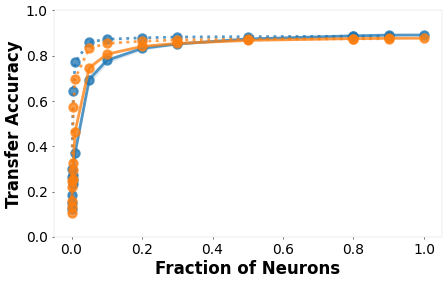

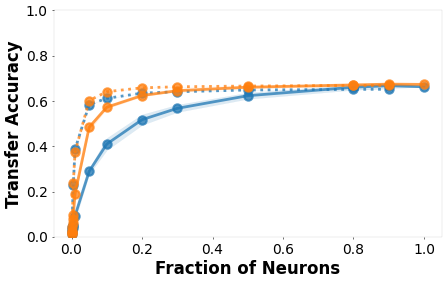

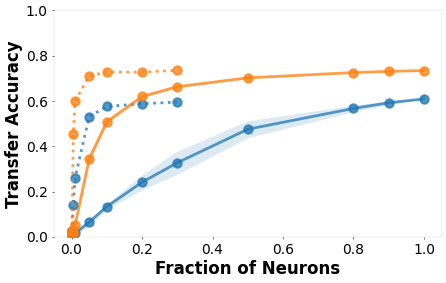

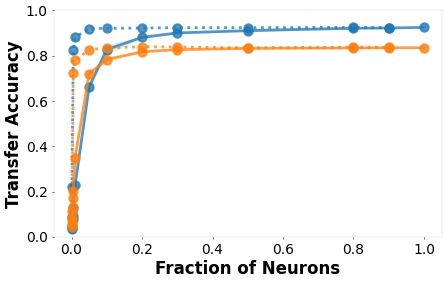

Uploading results in ['results/pca_comparison/imagenet'] to contact.mpi-sws.org...
Uploading 0 files to server


In [7]:
data_to_fracwise = results('resnet50', ['random', 'pca'], 'imagenet')

In [46]:
import importlib
importlib.reload(plt_hp)

<module 'plot_helper' from '../plot_helper.py'>

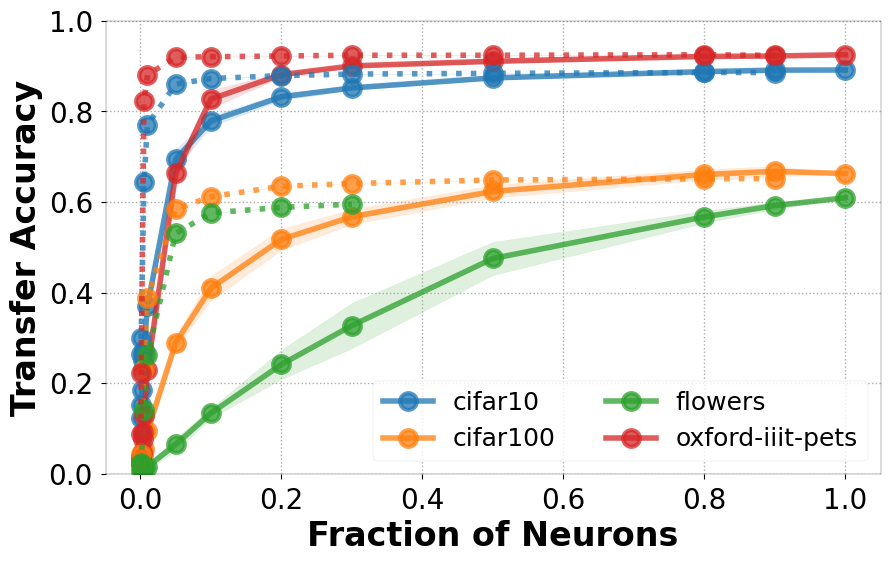

In [47]:
model = 'resnet50'
append = 'nonrob'
plotter(data_to_fracwise, model, append)

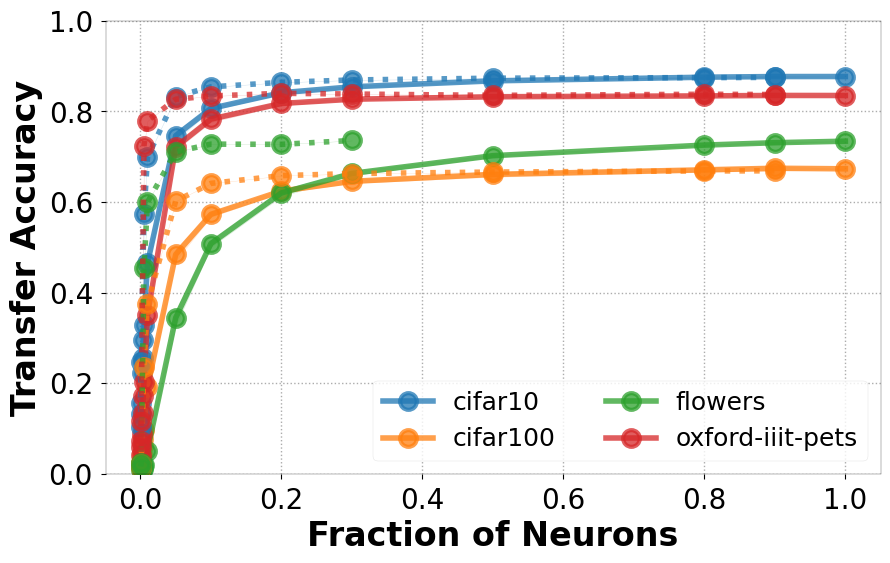

In [48]:
model = 'resnet50'
append = 'robustl2eps3'
plotter(data_to_fracwise, model, append)